In [7]:
import math
import numpy as np
np.random.seed(0)
import sys
import os
import scipy.sparse
np.set_printoptions(threshold=sys.maxsize)

current = os.path.dirname(os.path.realpath('__file__'))
parent = os.path.dirname(current)
parent = os.path.dirname(parent)
parent = os.path.dirname(parent)


sys.path.append(parent)

import benchmark
import tsp_qubo
import plotter
import annealing
        

In [8]:
class Parameters():
    '''Container for Qhea parameters'''
    def __init__(self, optimiziation_rate, n_individuals, n_generations, selection_pressure, bias):
        self.optimization_rate = optimiziation_rate
        self.n_individuals = n_individuals
        self.n_generations = n_generations
        self.selection_pressure = selection_pressure
        self.bias = bias

In [9]:
class Data():
    '''Container to collect data from the algorithm'''
    fitness = 0
    value = 1
    def __init__(self, individual):
        self.evolution = np.array([individual], dtype=object)
        self.all_time_fittest = individual.copy()

    def add_individual(self, individual):
        self.evolution = np.vstack([self.evolution, individual])
        if self.all_time_fittest[self.fitness] > individual[self.fitness]:
            self.all_time_fittest = individual.copy()

    def get_evolution(self):
        return self.evolution
    
    def get_fitness_evolution(self):
        return self.evolution[:, self.fitness]
    
    def get_individual_evolution(self):
        return self.evolution[:, self.value]
    
    def get_solution(self):
        return self.all_time_fittest

In [10]:
class Qhea():
    fitness = 0 # variable used to index individual for fitness
    value = 1 # variable used to index individual for value, eg. chromosome
    def __init__(self, qubo, parameters):
        '''
        :param qubo: qubo matrix  to optimize (minimize)
        :param parameters: Parameter oject with params to execute the algorithm
        '''
        self.qubo = qubo # save qubo
        self.sparse = scipy.sparse.coo_array(qubo)
        self.n_vars = len(qubo) # n_vars is the chromosome size, 2 ** n_vars is the solution space
        self.n_nodes = int(math.sqrt(self.n_vars))
        self.n_individuals = parameters.n_individuals # size of the population
        self.n_generations = parameters.n_generations # number of generations 
        self.selection_pressure = parameters.selection_pressure
        self.bias = parameters.bias
        self.optimization_rate = parameters.optimization_rate # probability of local_optimiztaion
        self.population, self.crossover_sequence, self.data, self.probabilities = self.init() # init data
        
        
    def init(self):
        population = np.array([[0, np.random.randint(0, 2, self.n_vars)] for j in range(self.n_individuals)],
                      dtype=object) # init population
        
        for ind in range(self.n_individuals):
            population[ind][self.fitness] = self.cost_function(population[ind][self.value]) # initial fitness to population
        
        population = population[population[:, self.fitness].argsort()] # sort ascending by fitness
        # self.clusters = self.get_sequences() # in this experiment, clusters serve as local optimization genomes
        crossover_sequence = np.array([0^(int(i / int(self.n_vars / 2)) > 0) for i in range(self.n_vars)])
        data = Data(population[0]) # init data object to collect data from algorithm
        
        probabilities = []

        for i in range(1, self.n_individuals+1):
            p = (1 / self.n_individuals) * (self.selection_pressure - (2 * self.selection_pressure - 2) * (
                (i - 1) / (self.n_individuals - 1)))
            probabilities.append(p)
        return population, crossover_sequence, data, probabilities
    
    def cost_function(self, val):
        return val @ self.sparse @ val # calculate fitness


    def derive_sub_qubo(self,slicing_equence, chromosome):
        sub_qubo = self.slice_qubo(slicing_equence,slicing_equence)
        freezing_sequence = np.logical_not(slicing_equence)
        freezed_genes = np.logical_and(freezing_sequence, chromosome)
        if np.sum(freezed_genes) != 0:

            sub_qubo_2 = np.transpose(self.slice_qubo(slicing_equence, freezed_genes))
            sub_qubo_3 = self.slice_qubo(freezed_genes, slicing_equence)
            
            sum = sub_qubo_2 + sub_qubo_3
            sum_axis = np.sum(sum, 0)
            diag = np.diag(sum_axis)
            sub_qubo += diag

        return sub_qubo
    

    def local_optimization(self, chromosome):
        r = np.random.uniform(0,1)
        if r < self.optimization_rate:
            order = np.random.permutation(len(chromosome))            
            for index in order:
                row = self.qubo[index]
                column = self.qubo[:, index]
                
                chromosome[index] = 1
                sums = np.add(row,column)
                if np.dot(chromosome,sums) - self.qubo[index][index] > 0:
                    chromosome[index] = 0
                
        return chromosome

  


    def optimize_sub_problem(self, sequence, chromosome):
        sub_qubo = self.derive_sub_qubo(sequence, chromosome)
        solution = annealing.d_wave.anneal(sub_qubo)[0].astype(int)
        s_i = np.where(sequence == 1)[0]
        result = np.array([chromosome[i] if i not in s_i else solution[np.where(s_i == i)[0][0]] for i in range(len(chromosome))])
        return result
    
    def slice_qubo(self,x,y):
        return self.qubo[np.ix_( np.where(x==1)[0], np.where(y==1)[0])]
    

    def uniform_crossover_sequence(self):
        probabilities = np.random.uniform(0.0, 1.0, self.n_vars)

        return probabilities > self.bias

    def optimize(self):

        for gen in range(self.n_generations): # evolution loop
            self.mutation_rate = 1 / (gen + 1)
            for ind in range(int(self.n_individuals / 2)): # iterating over the better half of individuals
                
                # mutation sequence is an array of [0,1], with a probabilty of mutation_rate for each index to be 1
                mutation_sequence_1 = np.random.random(self.n_vars) < self.mutation_rate # mutation sequence 1
                mutation_sequence_2 = np.random.random(self.n_vars) < self.mutation_rate # mutation sequence 2

                                 # selecting parents probabilistic
                parents = np.array([[0, np.random.randint(0, 2, self.n_vars)] for j in range(2)],
                      dtype=object)
                
                r = np.random.uniform(0,1,1)

                index_1 = (np.cumsum(self.probabilities)>r).argmax()
                parents[0] = self.population[index_1]

                r = np.random.uniform(0,1,1)
         
                # select parent_2        
                index_2 = (np.cumsum(self.probabilities)>r).argmax()
                parents[1] = self.population[index_2]
                # mutation sequence is an array of [0,1], with a probabilty of mutation_rate for each index to be 1
                mutation_sequence_1 = np.random.random(self.n_vars) < self.mutation_rate # mutation sequence 1
                mutation_sequence_2 = np.random.random(self.n_vars) < self.mutation_rate # mutation sequence 2
                self.crossover_sequence = self.uniform_crossover_sequence()
                # crossover with selected parents (first child), then mutation
                offspring_1_chromosome = np.logical_xor(
                np.add(
                    np.logical_and(parents[0][self.value], self.crossover_sequence), # getting the genes from first parent (where crossover is 1)
                    np.logical_and(parents[1][self.value], np.logical_xor(self.crossover_sequence, np.ones(self.n_vars))) # getting the genes from second parent (where crossover is 0)
                ),mutation_sequence_1)

                self.crossover_sequence = self.uniform_crossover_sequence()
                # crossover with selected parents (second child), then mutation
                offspring_2_chromosome = np.logical_xor(
                np.add(
                    np.logical_and(parents[1][self.value], self.crossover_sequence), # getting the genes from second parent (where crossover is 1)
                    np.logical_and(parents[0][self.value], np.logical_xor(self.crossover_sequence, np.ones(self.n_vars)))  # getting the genes from first parent (where crossover is 0)
                ), mutation_sequence_2)
                # note how the order of parents changed for individual 2
                self.population = np.vstack([self.population, np.array([0, offspring_1_chromosome], dtype=object)], dtype=object)
                self.population = np.vstack([self.population, np.array([0, offspring_2_chromosome], dtype=object)], dtype=object)

                offspring_1_chromosome = self.local_optimization(offspring_1_chromosome)
                offspring_2_chromosome = self.local_optimization(offspring_2_chromosome)
                
                
            # apply fitness to every new individual
            for ind in range(self.n_individuals, len(self.population)):
                self.population[ind][self.fitness] = self.cost_function(self.population[ind][self.value])
            
            # sort ascending by fitness
            self.population = self.population[self.population[:, self.fitness].argsort()]
            self.population = self.population[:self.n_individuals]
            # add fittest individual to data set
            self.data.add_individual(self.population[0])
        
        # when done, return data set
        return self.data
    
    def get_clusters(self):
        clusters = np.zeros((self.n_nodes, self.n_nodes))
        cluster_c = int(self.n_nodes / self.cluster_size)

        for n in range(self.n_clusters):
            amp = np.zeros((cluster_c, cluster_c))
            amp[n % cluster_c][int(n / cluster_c)] = 1
            cluster = np.ones((self.cluster_size, self.cluster_size)) * n
            clusters += np.kron(amp, cluster)

        return np.reshape(clusters, self.n_vars)


    def get_sequences(self):
        
        clusters = self.get_clusters()
        cluster_sequences = np.array([np.zeros(self.n_vars) for i in range(self.n_clusters)])
        for i in range(self.n_clusters):
            cluster_sequences[i] = np.array([0 ^ (i == int(clusters[j])) for j in range(self.n_vars)])
        
        
        return cluster_sequences

In [11]:
tsp = benchmark.distances.get_tsp(benchmark.distances.get_tsp_names()[4]).distances
n_nodes = len(tsp)
penalty = 100
constraint_matrix = np.zeros((n_nodes ** 2, n_nodes ** 2))
constraint_matrix = tsp_qubo.generate.apply_penalties(constraint_matrix, penalty)

amp = np.zeros((n_nodes, n_nodes))
for i in range(len(amp)):
    amp[i][(i + 1) % n_nodes] = 1
objective = np.kron(amp, tsp)
qubo = objective + constraint_matrix


[-8266.0, -8191.0, -8371.0, -8197.0, -8231.0]


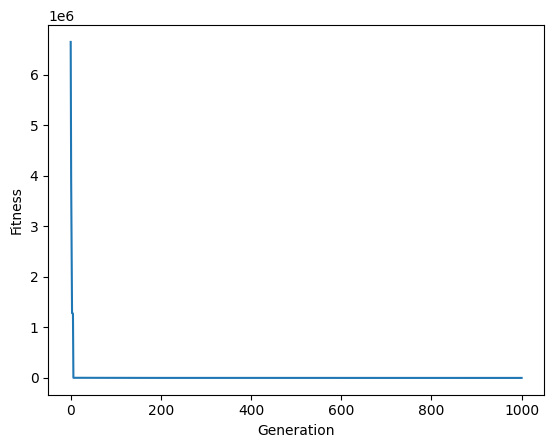

In [12]:
parameters = Parameters(
    optimiziation_rate=0.005,
    n_individuals=100,
    n_generations=1000,
    selection_pressure=2,
    bias=0.5
)

evolutions = np.array([0 for i in range(parameters.n_generations+1)], dtype=object)
histogramm = []
for i in range(5):
    solver = Qhea(qubo=qubo,parameters=parameters)
    result = solver.optimize()
    evolution = result.get_fitness_evolution()
    evolutions = np.add(evolutions, evolution)
    histogramm.append(result.all_time_fittest[0])

evolutions = evolutions / 5
print(repr(histogramm))
plotter.plot_evolution(evolutions, "one_iterative_unordered_0.5%", 2)

## Experiment Description
The Algorithm was tested with a medium mutation rate of 5% probability. 

## Result
<img src="files/local_optimization_cluster_large.png">